# Introduction to Equivariant Modelling

## Table of contents:
* [Symmetry in Materials Science](#symmetry-in-materials-science)
* [Why Equivariance?](#why-equivariance)
* [What is Equivariance?](#what-is-equivariance)

Author: Karan Bania | [web](https://karannb.github.io)

In this tutorial we will explore the basics of equivariance (with some math) and also a concrete example of using Neural Networks equipped with equivariant layers. No mathematical background is required, we will also provide references for further reading in case you are interested. Equivariance is a powerful concept which adequately represents the **symmetries** present in Materials Science applications and thus is an invaluable tool. This tutorial follows the `Introduction to Equivariance` tutorial where we focused on invariance. (not a pre-requisite for this tutorial)

As we will learn, equivariant methods are becoming more and more popular in the field of Computational Materials Science and Chemistry. We are not building a model in this tutorial, the scope here is to understand the concept and it's impact on the field. This tutorial is inspired from the [MRS 2021 tutorial series](https://e3nn.org/e3nn-tutorial-mrs-fall-2021/) and Andrew White's [digital book](https://dmol.pub/dl/Equivariant.html) on DL for Materials and Molecules.

This notebook can be run on Google CoLab, but as we do not have any significant training to do, it can be run on your local machine as well.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Introduction_To_Equivariant_Modelling.ipynb)

#### Packages and utility functions (feel free to skip this part)

In [1]:
# Packages
import numpy as np
np.random.seed(0)

from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def getMethane() -> np.ndarray:
    '''
    Returns the 3D coordinates of a methane molecule.
    '''
    
    # Create a methane molecule from SMILES
    methane_smiles = "C"
    methane_molecule = Chem.MolFromSmiles(methane_smiles)
    # Add hydrogens to the molecule
    methane_molecule = Chem.AddHs(methane_molecule)
    # Generate 3D coordinates
    AllChem.EmbedMolecule(methane_molecule)
    # Get the conformer to access 3D coordinates
    conformer = methane_molecule.GetConformer()
    # Extract coordinates into a NumPy array
    num_atoms = methane_molecule.GetNumAtoms()
    mol = np.zeros((num_atoms, 3))
    for i in range(num_atoms):
        position = conformer.GetAtomPosition(i)
        mol[i] = [position.x, position.y, position.z]
        
    return mol

def formatVector(vec: np.ndarray, precision=3) -> str:
    '''
    Urility for pretty printing a vector.
    '''
    
    round_off_str = "{:." + str(precision) + "f}"
    if vec.ndim == 1:
        output = "["
        for i in range(len(vec)):
            output += round_off_str.format(vec[i])
            if i < len(vec) - 1:
                output += ", "
        output += "]"
        
    elif vec.ndim == 2:
        output = "[\n"
        for i in range(len(vec)):
            output += "["
            for j in range(len(vec[i])):
                output += round_off_str.format(vec[i, j])
                if j < len(vec[i]) - 1:
                    output += ", "
            output += "]"
            if i < len(vec) - 1:
                output += ",\n"
        output += "\n]"
    
    return output

def displayMols(mol, mol_rotated) -> None:
    '''
    Displays the original and rotated methane molecules.
    '''
    
    # Create a 3D plot
    fig = plt.figure(figsize=(8, 4))

    # Original molecule
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(mol[0, 0], mol[0, 1], mol[0, 2], c='k', s=100, label='C')
    ax1.scatter(mol[1:, 0], mol[1:, 1], mol[1:, 2], c='r', s=50, label='H')
    for i in range(1, 5):
        ax1.plot([mol[0, 0], mol[i, 0]], 
                [mol[0, 1], mol[i, 1]], 
                [mol[0, 2], mol[i, 2]], 'k-')
    ax1.set_title('Original Methane')
    ax1.legend()

    # Rotated molecule
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(mol_rotated[0, 0], mol_rotated[0, 1], mol_rotated[0, 2], c='k', s=100, label='C')
    ax2.scatter(mol_rotated[1:, 0], mol_rotated[1:, 1], mol_rotated[1:, 2], c='b', s=50, label='H')
    for i in range(1, 5):
        ax2.plot([mol_rotated[0, 0], mol_rotated[i, 0]], 
                [mol_rotated[0, 1], mol_rotated[i, 1]], 
                [mol_rotated[0, 2], mol_rotated[i, 2]], 'k-')
    ax2.set_title('Rotated Methane')
    ax2.legend()

    # Set equal aspect ratio
    ax1.set_box_aspect((1,1,1))
    ax2.set_box_aspect((1,1,1))
    ax1.set_axis_off()
    ax2.set_axis_off()

    plt.tight_layout()
    plt.show()
    
    return

def relu(x: np.ndarray) -> np.ndarray:
    '''
    Rectified Linear Unit (ReLU) activation function.
    '''
    
    return np.maximum(0, x, x)

## Symmetry in Materials Science

#### Why Symmetry?
Before going into too much detail about Equivariance, we might just ask, why use any symmetry preserving methods at all?

To answer this, we need to understand that **we** model the physical world around us using coordinate systems and Euclidean Geometry, but, these are **non-existent** in the real world! There is no universal reference frame. As such, we have already biased our models to a particular view, and we would like to remove these biases. In certain applications, the effect of these biases is not pronounced, for example, if you have ever worked with images, we can make the model unbiased / **invariant** to rotations by simply rotating a few training images (or sometimes even this is not necessary). Informally, this happens because the "number" of symmetries in the data is small, and we can easily account for them by augmenting the data. However, in our case, making a model invariant to all possible rotations of a molecule would require us to do a massive amount of augmentation, about **500x**. Thus, our use-case necessiates the use of some form of symmetry aware representations and/or models.

#### Example

To be concrete, let's consider the example of a methane molecule. Suppose we create a model to predict some property, say the charge of a methane molecule, based on it's 3D coordinates (might be a bad model but atleast it will do something).

In [2]:
# Get a methane molecule
mol = getMethane()

# Display the Coordinates
print("Methane coordinates (in Ångströms):")
print(mol)

Methane coordinates (in Ångströms):
[[-0.02209687  0.00321505  0.01651974]
 [-0.66900878  0.88935986 -0.1009085 ]
 [-0.37778794 -0.85775189 -0.58829603]
 [ 0.09642092 -0.3151253   1.06378087]
 [ 0.97247267  0.28030227 -0.39109608]]


In [3]:
w1, b1 = np.random.randn(5*3, 2), np.random.randn(2) # 5*3 because we have 5 atoms in CH4 and 3 coordinates for each atom
w2, b2 = np.random.randn(2, 1), np.random.randn(1)

def nn(mol, w1, b1, w2, b2) -> np.ndarray:
    '''
    Forward pass of a simple neural network.
    '''
    mol = mol.flatten()
    out = relu(np.dot(mol, w1) + b1)
    out = np.dot(out, w2) + b2
    return out

# do a forward pass
output = nn(mol, w1, b1, w2, b2)
print(f"Output: {formatVector(output)}")

Output: [-1.445]


As the model is not trained, we don't care about the output. Now suppose we rotate our molecule by 90 degrees about the x-axis, the charge of the molecule should not change, but our model will predict a different charge. And although right now the weights are random, no matter how much data we train on, our model, by design, will always predict a different charge for the rotated molecule.

In [4]:
# create a rotation matrix that rotates 90 degrees around the x-axis
r = R.from_rotvec(np.pi/2 * np.array([1, 0, 0]))
# rotate the molecule
mol_rotated = r.apply(mol)

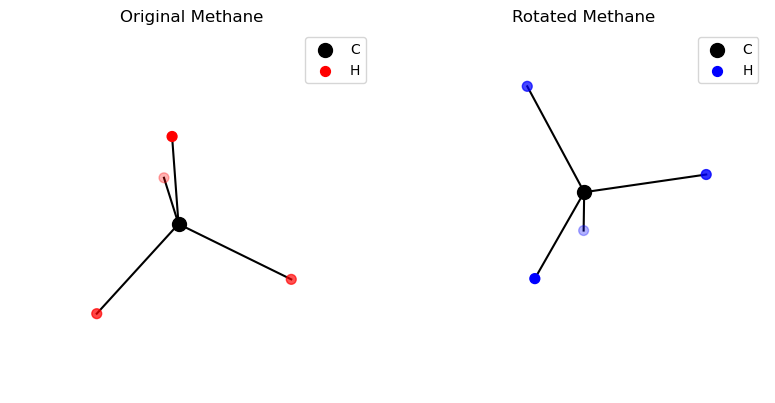

In [5]:
# Display original and rotated molecule
displayMols(mol, mol_rotated)

In [6]:
output_rotated = nn(mol_rotated, w1, b1, w2, b2)
print(f"Rotated Output: {formatVector(output_rotated)}")

print(f"Difference in output: {formatVector(output - output_rotated)}")

Rotated Output: [-4.309]
Difference in output: [2.864]


Clearly, there is a non-zero difference in the output. As an example let's try to make a model that is invariant to rotations about the x-axis. Simply enough we just have to sum across the varying axes!

In [7]:
wy = np.random.randn(1)
wz = np.random.randn(1)
wx, b = np.random.randn(5, 1), np.random.randn(1) # only 5 because wx will be applied to each atom's x-coordinate only

def invariant_nn(mol, wx, wy, wz, b) -> np.ndarray:
    '''
    Forward pass of a simple neural network with rotational-invariance properties.
    '''
    mol_xs = mol[:, 0]
    mol_ys = np.sum(mol[:, 1])
    mol_zs = np.sum(mol[:, 2])
    
    x_feat = np.dot(mol_xs, wx)
    y_feat = wy * mol_ys
    z_feat = wz * mol_zs
    out = relu(x_feat) + relu(y_feat) + relu(z_feat) + b
    return out

In [8]:
output_invariant = invariant_nn(mol, wx, wy, wz, b)
output_rotated_invariant = invariant_nn(mol_rotated, wx, wy, wz, b)

print("Output: {}".format(output_invariant))
print("Rotated Output: {}".format(output_rotated_invariant))
print("Difference in output: {}".format(output_invariant - output_rotated_invariant))

Output: [-1.70627019]
Rotated Output: [-1.70627019]
Difference in output: [-2.22044605e-16]


Nice, our model is now invariant to rotations about the x-axis, but what about the y-axis / z-axis? What about translations? What about reflections? We can build a general model that is **invariant** to all these transformations, and we would direct the interested reader to [Ch.9 Input Data and Equivariances](https://dmol.pub/dl/data.html) for a detailed discussion on this.

#### Some jargon from Materials Science (briefly)
This slight detour is to introduce a few terms we will use in the next section.
- **Phonons**: As atoms in crystal lattices are strongly connected, displacement of even one of them gives rise to a set of vibration waves propagating through the crystal. These waves can have arbitrary frequencies (there exists a maximum uper bound) but their normal modes have fixed frequencies, and these quantized modes are the ones we are interested in. These are very important to a solid's thermal conductivity, electrical conductivity, acoustic properties, to name a few. This <a href="https://www.youtube.com/watch?v=KY0yyrLIc8c">video</a> is a good introduction.

- **Charge Density**: This is a very general term, and refers to the distribution of charge on any surface or volume. However, in context of Materials Science, we are usually interested in the charge density of a molecule or a crystal structure. This is essential to density functional theory (DFT) calculations, and is used to derive *all* chemical properties of a material.

## Why Equivariance?

Now an obvious question arises, why not just use invariance? Why do we need equivariance?
- The math involved is quite advanced,
- These methods are tough to implement,
- A unified implementation framework is also absent, though <a href="https://e3nn.org/">e3nn</a> has come quite far to solving this problem.

Despite these, it is encouraging to note that methods using equivariance are currently State-of-the-art (/ only models to do the task with a reasonable performance!) in many computational benchmarks with Materials Science applications, for e.g., phonon prediction [Fang et. al, 2024](https://doi.org/10.48550/arXiv.2403.11347); or charge density prediction [Fu et. al, 2024](https://doi.org/10.48550/arXiv.2405.19276). Such networks have also been used for generating unique 3D molecular structures ([Daigvane et. al, 2023](https://doi.org/10.48550/arXiv.2311.16199)).

<center>

| Metric (&uarr;) | Symphony (Uses Equivariancs) | G-SchNet (Does not use Equivariance) | G-SphereNet (Does not use Equivariance) |
| :--------------: | :--------------------------: | :----------------------------------: | :------------------------------------: |
| Validity using xyz2mol(%) | **83.5** | 74.97 | 26.92 |
| Uniqueness using xyz2mol(%) | **97.8** | 96.73 | 21.69 |

Results from Daigvane et. al, 2023 showing the effectiveness of Symphony over other methods in generating unique 3D molecular structures.
</center>

#### Data efficiency and Scalability
Apart from these explicit high-level results, Equivariant modelling is also highly data-efficient compared to other methods. This follows from the discussion we had about augmentations and symmetry, needless to say this is a significant advantage, because data for Materials Science applications is often scarce and expensive to generate, and the computational cost of running simulations is very high. Using equivariant models can help us save on both these fronts.

<center>

| Method | NMAE[\%] (&darr;) | Molecules/min. |
| :----: | :---------------: | :------------: |
| ChargE3Net (Partially Equivariant) | 0.196 ± 0.001 | 3.95 |
| InfGCN (Invariant) | 0.869 ± 0.002 | 72.00 |
| Best eSCN (Fully Equivariant) | **0.178 ± 0.001** | **125.29** |

Results from Fu et. al, 2024 showing the efficiency of their network eSCN over other methods in predicting charge density.
</center>


#### Real life impact
With the proliferation of this knowledge, these models are now also being applied to protein folding ([AlphaFold-3](https://doi.org/10.1038/s41586-024-07487-w) which is again State-of-the-art (SOTA) on multiple benchmarks), and materials exploration / generation on scale ([GNoME](https://doi.org/10.1038/s41586-023-06735-9)), these methods have equivariance at the very heart of their models. Predictions from GNoME are also being used to synthesize materials with *specific properties*, which is a testament to the power of these methods.

<p float="left" align="center">
  <img src="assets/Intro-To-Equi-tutorial/AF3-generated-molecule.png" align="center" width="450"/>
  <img src="assets/Intro-To-Equi-tutorial/GNoME.png" align="center" width="400"/>
  <center> <i>Left</i>: A molecule generated by AlphaFold-3, <i>Right</i>: Impact of GNoME on Materials Discovery. </center>
</p>

Finally, we would also like to point out the methods involved are very interesting as they **supply** the model with information on **how** we represent 3D structures in real life and definitely warrant a read.

## What is Equivariance?

In general, equivariance is a form of symmetry for functions. Equivariance is easy to define and understand once we know what a **group** is and what a **representation** is. This section involves some math but we will try to keep it as simple as possible.

#### Group
Intuitively a group consists of transformations and decides how they **compose and interact** with each other. Formally, we say that a set of transformations $G$ is a group if:
- There exists an identity element $e \in G$ such that $eg = ge = g$ for all $g \in G$.
- For all $g \in G$, there exists an inverse $g^{-1}$ such that $gg^{-1} = g^{-1}g = e$.
- The composition of two transformations is also an transformation, i.e., for all $g, h \in G$, $gh \in G$.

#### Representation
This is a little more abstract than the notion of a group. The basis behind representation theory is to allow us to do abstract algebra (e.g. Matrix Multiplication) on some vector space. Thus a representation exists only in context of a group **and** a vector space. A representation is like defining the **data-types**, it decides how a particular group element transforms a particular **type** of vector. Formally, the representation of a group $G$ **on** a vector space $V$, written as $D(g, x)$ follows the following rules:
- Linearity, $D(g, x + y) = D(g, x) + D(g, y)$.
- Commutativity, $D(g, D(h, x)) = D(gh, x)$.

where $x, y \in V$ and $g, h \in G$.

However, we usually view the transformations in a group as matrices, so we also have this equivalent notation, written as $D(g) \times x$, such that:
- $D(g): V \rightarrow V$, $D(g) \in \mathbb{R}^{n \times n}$, where $n$ is the dimension of $V$.
- $D(g)D(h) = D(gh)$.

Let's take an example to understand these two concepts better.

In [9]:
# suppose our group consists of rotations of arbitrary rotations
# and our space is the Euclidean 3D space.

# create a rotation matrix
alpha, beta, gamma = np.random.rand(3) * 2 * np.pi
r = R.from_euler('xyz', [alpha, beta, gamma]) # D(g)

vec = np.random.randn(3) # v

vec_ = r.apply(vec) # D(g)v

This was a really simple example, however, it can get complicated if the representations are not just plain numbers! For example, suppose we have a 2 atom system where we know the masses of the atoms and their velocities. We couple this information into a single 8 dimensional vector ($[m_1, m_2, v_{1x}, v_{1y}, v_{1z}, v_{2x}, v_{2y}, v_{2z}] \in \mathbb{R}^8$). Now, our system description is **still** in 3D but our representation is now 8D.

Also, we know that masses don't change under rotations (scalars, a particular **type of representation**), but velocities do (vector, another type of representation). For now we also assume these two velocities are independent of each other (in practice this is not the case). When we build a model, We need to encode this information to the model in some way.

Let's build a rotation matrix that obeys these properties.

In [10]:
m1_block = np.ones((1, 1)) # scalars don't change
m2_block = np.ones((1, 1))
v1_block = r # independent rotations
v2_block = r

row1 = np.concatenate([m1_block, np.zeros((1, 1)), np.zeros((1, 3)), np.zeros((1, 3))], axis=-1)
row2 = np.concatenate([np.zeros((1, 1)), m2_block, np.zeros((1, 3)), np.zeros((1, 3))], axis=-1)
row3 = np.concatenate([np.zeros((3, 1)), np.zeros((3, 1)), v1_block.as_matrix(), np.zeros((3, 3))], axis=-1)
row4 = np.concatenate([np.zeros((3, 1)), np.zeros((3, 1)), np.zeros((3, 3)), v2_block.as_matrix()], axis=-1)

R_prime = np.block([
    [row1],
    [row2],
    [row3],
    [row4]
])

print(f"R': {formatVector(R_prime, precision=2)}")

R': [
[1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
[0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
[0.00, 0.00, 0.20, -0.98, 0.08, 0.00, 0.00, 0.00],
[0.00, 0.00, 0.77, 0.21, 0.60, 0.00, 0.00, 0.00],
[0.00, 0.00, -0.60, -0.06, 0.80, 0.00, 0.00, 0.00],
[0.00, 0.00, 0.00, 0.00, 0.00, 0.20, -0.98, 0.08],
[0.00, 0.00, 0.00, 0.00, 0.00, 0.77, 0.21, 0.60],
[0.00, 0.00, 0.00, 0.00, 0.00, -0.60, -0.06, 0.80]
]


It is a block diagonal matrix.

#### Equivariance

Now we are ready to define equivariance. Again, formally, given a function $f: V \rightarrow V'$, a group element $g \in G$, representations $D$ and $D'$ of $G$ on $V$ and $V'$ respectively, we say that $f$ is equivariant to $G$ if for all $x \in V$, we have 
$$
f(D(g)x) = D'(g)f(x)
$$

That was really abstract, let's break it down. Intuitively, we want our function to act on the transformed input in the same way as the original input. But this is still quite high-level, consider this example to understand it better. Suppose we are working with 3D coordinates and $g$ just cycles the coordinates clockwise (permutation). Then 
$$f([x, y, z]) = [z + y, x + z, x + y]$$ 
is equivarant to $g$, because 
$$f(g[x, y, z]) = f([z, x, y]) = [x + y, y + z, z + x]$$
$$g' f([x, y, z]) = g' [z + y, x + z, x + y] = [x + y, y + z, z + x]$$

where $g' = g$. (This is the same math that makes GNN layers permutationally equivariant).

In [11]:
def f(x: np.ndarray) -> np.ndarray:
    y = [x[1] + x[2], x[0] + x[2], x[0] + x[1]]
    return np.array(y)

v1 = np.array([1, 2, 3])
print(f"Vector (v1): {v1}")
permutation = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]) # Permutation matrix
print(f"Permutation matrix (g): \n{permutation}")
permuted_v1 = np.dot(permutation, v1) # Permutes the vector
print(f"Permuted vector (g*v1): {permuted_v1}")
out_permuted_f1 = f(permuted_v1)
print(f"Output on permuted vector f1(g*v1): {out_permuted_f1}")
out_f1 = f(v1)
permuted_out_f1 = np.dot(permutation, out_f1)
print(f"Output on vector g'f1(v1): {permuted_out_f1}")

Vector (v1): [1 2 3]
Permutation matrix (g): 
[[0 1 0]
 [1 0 0]
 [0 0 1]]
Permuted vector (g*v1): [2 1 3]
Output on permuted vector f1(g*v1): [4 5 3]
Output on vector g'f1(v1): [4 5 3]


#### What does this mean for Machine Learning?
- **Data efficiency**: As we have seen, we can encode a lot of information about the data into the model, and this can help us learn from less data. (Leftmost figure)
- **Easy Learnability**: Note how our data is inherently equivariant, if we try to learn a model that is not equivariant the model will have to learn the symmetries from the data, which is a much harder task. By limiting the space of functions we can learn, we can learn faster. (Middle two figures)
- **Improved Generalization**: Equivariant models have the advantage of generalizing well to unseen data. By incorporating the known symmetries into the model architecture, equivariance ensures that the model can effectively capture and utilize these patterns even when presented with novel examples. This leads to improved generalization performance.
- **Extra**: Using equivariant models we can build models that can predict a property in any configuration after seeing just one example! (Rightmost figure shows a gif of interaction energies between the orbitals of a water molecule)

<p align="center">
  <img src="assets/Intro-To-Equi-tutorial/data-efficiency.png" width="400"/>
  <br>
  <center>
    <i>Data Efficiency</i>: An illustration showing the impact of data efficiency.
  </center>
</p>

<p align="center">
  <img src="assets/Intro-To-Equi-tutorial/learnability1.png" width="400"/>
  <img src="assets/Intro-To-Equi-tutorial/learnability2.png" width="400"/>
  <br>
  <center>
    <i>Left:</i> How equivariance limits function space, <i>Right:</i> Equivariance vs Invariance with reference to the function space.
  </center>
</p>

<p align="center">
  <img src="assets/Intro-To-Equi-tutorial/INTERACTION-ENERGY.gif" width="400"/>
  <br>
  <center>
    <i>Interaction Energy:</i> Predicting interaction energy in any orientation.
    <br>
    These images have been derived from the MRS tutorial <a href="https://docs.google.com/presentation/d/1y-fCZihLoSBgAqNYKZY1-jy8qpvqagqPTsX-jR0uTm8/edit#slide=id.gfc16e347b8_0_634">here</a>.
  </center>
</p>

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!